In [1]:

from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader


In [2]:

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        return encoding

In [3]:
import os
import shutil

dataset_path = r"..\dataset\rhwu_v5"


def split_from_csv(dataset_path):
    """
    make folder from csv files  
    :param dataset_path: 
    :return: 
    :param dataset_path: 
    :return: 
    """

    for file in ['train.csv', 'val.csv', 'test.csv']:
        file_path = os.path.join(dataset_path, file)
        with open(file_path) as f:
            lines = f.readlines()
            for line in lines[1:]:
                parts = line.split(",")
                if len(parts) != 2:
                    continue
                _dir = os.path.join(dataset_path, file[:-4])
                if not os.path.exists(_dir):
                    print("make _dir :", _dir)
                    os.makedirs(_dir)
                shutil.copy2(os.path.join(dataset_path, "images", parts[0]), _dir)
            shutil.copyfile(file_path, os.path.join(_dir, "metadata.csv"))

In [4]:
dataset_path = r"..\dataset\rhwu_v5"
# split_from_csv(dataset_path)

In [4]:


dataset = load_dataset("imagefolder", data_dir=os.path.join(dataset_path, "val"), split="train")

Resolving data files:   0%|          | 0/345 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [34]:

from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

model_dir = r"E:\medical\depth\runs_remote\blip11\best"
processor = AutoProcessor.from_pretrained(model_dir)

model = BlipForConditionalGeneration.from_pretrained(model_dir)


In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(device)

cuda


Resolving data files:   0%|          | 0/345 [00:00<?, ?it/s]

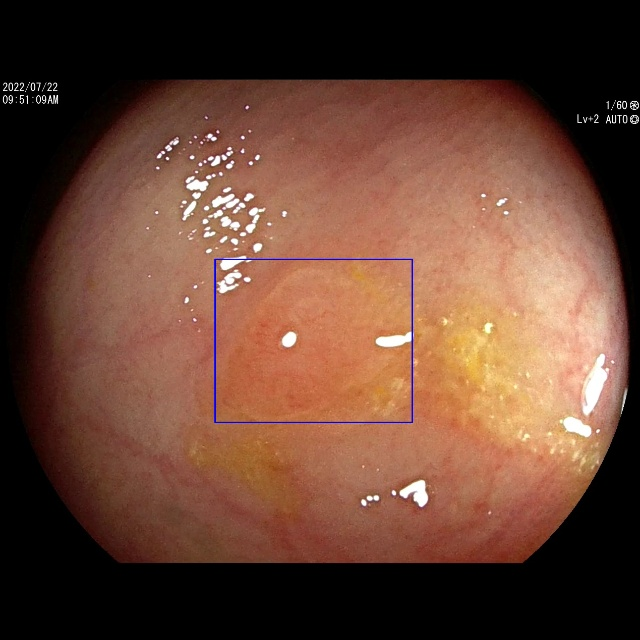

In [52]:
data_dir = os.path.join(dataset_path, "val")
test_dataset = load_dataset("imagefolder", data_dir=data_dir, split="train")

example = test_dataset[0]
image = example["image"]
image

In [42]:
def classify_step(txt, labels):
    label_num = len(labels)
    v = int(txt.replace("mm", ""))
    p_size = 0
    for i in range(0, label_num):
        step = labels[i]
        if v >= int(step):
            p_size = i
            if i + 1 < label_num:
                next_step = int(labels[i + 1])
                if v < next_step:
                    # find near step
                    if v - int(step) >= int(next_step) - v:
                        p_size = i + 1
                        break

    return p_size

In [54]:
import pandas as pd

df = pd.read_csv(os.path.join(data_dir, 'metadata.csv'), encoding='utf-8')
df['pred'] = ''
df.head(3)

,file_name,text,pred
0,H4_P138_S4_R115_27_140.jpg,The actual size of the lesions in the blue box...,
1,H4_P138_S4_R105_27_141.jpg,The actual size of the lesions in the blue box...,
2,H4_P138_S4_R104_27_142.jpg,The actual size of the lesions in the blue box...,


In [59]:
df.loc[0, 'pred'] = '2'
df.head(3)

,file_name,text,pred
0,H4_P138_S4_R115_27_140.jpg,The actual size of the lesions in the blue box...,2
1,H4_P138_S4_R105_27_141.jpg,The actual size of the lesions in the blue box...,
2,H4_P138_S4_R104_27_142.jpg,The actual size of the lesions in the blue box...,


In [9]:
import re

txt = 'the size of the lesions in the blue box at the close distance is 5 mm'
result = re.findall('far|appropriate|close', txt)
print(result)

['close']


In [79]:
import re
from tqdm import tqdm


def decode_result(input_id, output_id):
    p_size = get_val(r"(\d+)\smm", output_id)
    g_size = get_val(r"(\d+)\smm", input_id)
    p_dis = get_val('far|appropriate|close', output_id)
    g_dis = get_val('far|appropriate|close', input_id)
    #in pixels width 12 height 12
    p_w = get_val(r"(\d+)\sheight", output_id)
    g_w = get_val(r"(\d+)\sheight", input_id)
    p_h = get_val(r"height\s(\d+)", output_id)
    g_h = get_val(r"height\s(\d+)", input_id)
    stat = {"pred": p_size, 'label': g_size, 'pred_dis': p_dis, 'label_dis': g_dis
        , 'pred_w': p_w, 'label_w': g_w, 'pred_h': p_h, 'label_h': g_h, 'output': output_id}
    return stat


stats = []

for i in tqdm(range(len(test_dataset))):
    image, txt = example["image"], example["text"]
    inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    df.loc[i, 'pred'] = txt
    stat = decode_result(txt, generated_caption)
    stats.append(stat)

stats[:3]

  0%|          | 0/344 [00:01<?, ?it/s]


[{'pred': '4',
  'label': '5',
  'pred_dis': None,
  'label_dis': None,
  'pred_w': '17',
  'label_w': '20',
  'pred_h': '17',
  'label_h': '16',
  'output': 'the actual size of the lesions in the blue box is about 4 mm in pixels width 17 height 17'}]

In [76]:


_dataset = ImageCaptioningDataset(test_dataset, processor)
test_dataloader = DataLoader(_dataset, shuffle=False, batch_size=16)
stats = []


def get_val(reg, txt):
    val = re.findall(reg, txt)
    if val:
        return val[0]
    return None


k = 0

for idx, batch in enumerate(tqdm(test_dataloader)):
    input_ids = processor.batch_decode(batch.pop("input_ids"))

    pixel_values = batch.pop("pixel_values").to(device)
    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    output_ids = processor.batch_decode(generated_ids, skip_special_tokens=True)
    for i in range(len(output_ids)):
        try:
            output_id = output_ids[i].replace('[SEP]', '').replace('[CLS]', '')
            input_id = input_ids[i].replace('[SEP]', '').replace('[PAD]', '')

            stat = decode_result()
            stats.append(stat)
        except Exception as e:
            print(output_ids[i])
    # break
print(stats[:3])

100%|██████████| 344/344 [02:21<00:00,  2.43it/s]

[{'pred': '4', 'label': '5', 'pred_dis': None, 'label_dis': None, 'pred_w': '17', 'label_w': '20', 'pred_h': '17', 'label_h': '16', 'output': 'the actual size of the lesions in the blue box is about 4 mm in pixels width 17 height 17'}, {'pred': '4', 'label': '5', 'pred_dis': None, 'label_dis': None, 'pred_w': '19', 'label_w': '20', 'pred_h': '21', 'label_h': '16', 'output': 'the actual size of the lesions in the blue box is about 4 mm in pixels width 19 height 21'}, {'pred': '4', 'label': '5', 'pred_dis': None, 'label_dis': None, 'pred_w': '7', 'label_w': '6', 'pred_h': '7', 'label_h': '9', 'output': 'the actual size of the lesions in the blue box is about 4 mm in pixels width 7 height 7'}]


In [77]:
df['new_text'] = ''
for i in range(len(stats)):
    stat = stats[i]
    diff = (int(stat['pred']) - int(stat['label']))
    append = ''
    thresh = max(1, round(int(stat['label']) * 0.15))
    if diff > thresh:
        append = ' and looks smaller'
    elif diff < -thresh:
        append = ' and looks larger'
    df.loc[i, 'new_text'] = df.loc[i, 'text'] + append
df.head(3)
df.to_csv(os.path.join(data_dir, 'metadata.csv'))

3

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from angel.plot import Plot


def show_matrix(y_pred, y_true, labels, out_put_dir, tag="", normalize=False):
    cnf_matrix = confusion_matrix(y_pred, y_true)
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(12, 9), tight_layout=True)

    Plot.plot_confusion_matrix(cnf_matrix, classes=labels,
                               title='Confusion matrix', normalize=normalize)
    file_path = os.path.join(out_put_dir, f'matrix_{tag}_{normalize}.jpg')
    plt.savefig(file_path, dpi=250)
    print("save plot image to : ", file_path)


In [105]:
import numpy as np


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, 2)
        print("Normalized confusion matrix")

    thresh = cm.max() / 2.
    for i, j in zip(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="gray" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predict')
    plt.xlabel('True')

E:\medical\depth\efficientteacher\angel\plot.py:180: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
save plot image to :  E:\medical\depth\runs_remote\blip11\best\matrix_pixel_w_True.jpg
save plot image to :  E:\medical\depth\runs_remote\blip11\best\matrix_pixel_w_False.jpg


<Figure size 640x480 with 0 Axes>

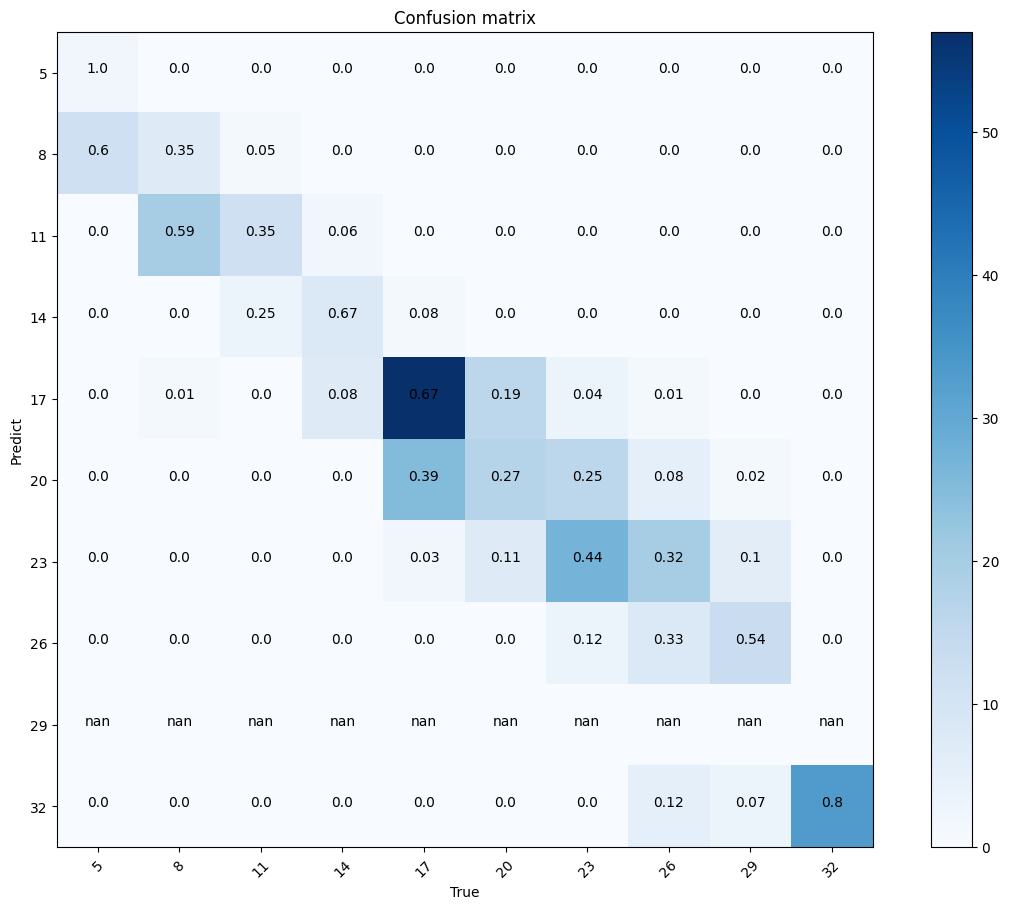

<Figure size 640x480 with 0 Axes>

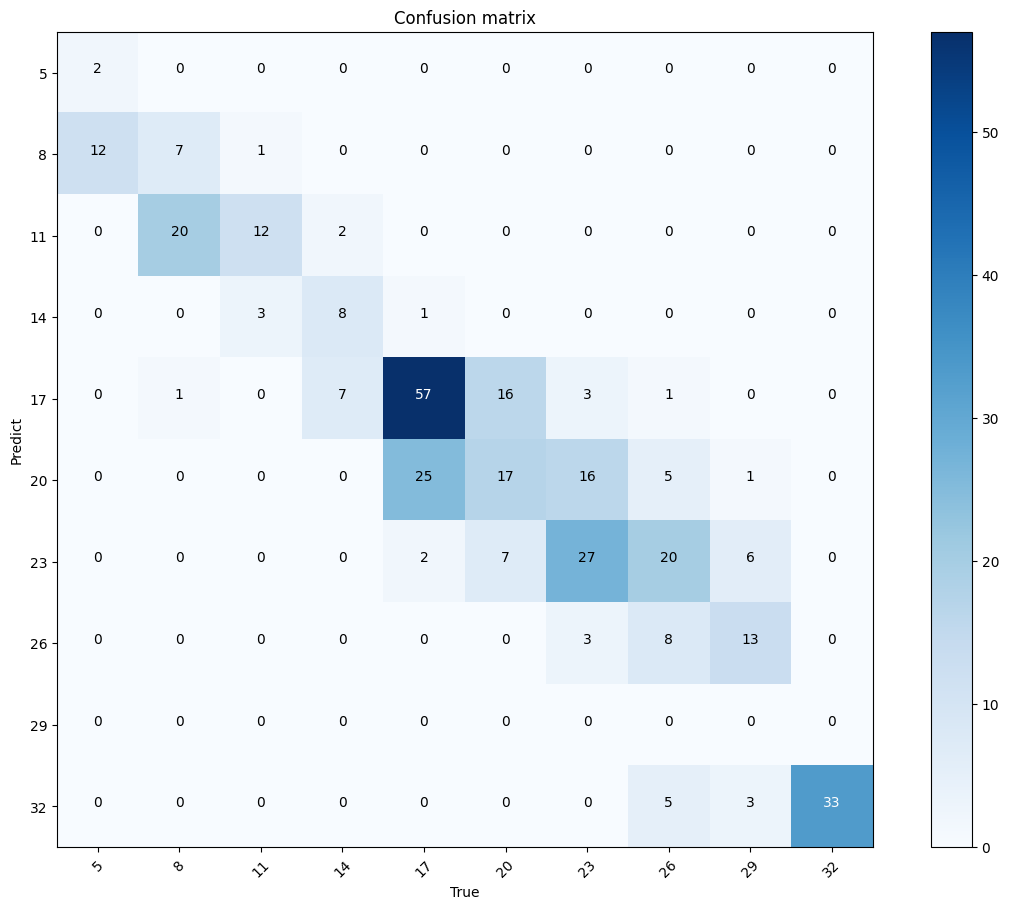

In [46]:


labels = [str(i) for i in range(5, 35, 3)]
pred = [stat['pred_w'] for stat in stats]
gt = [stat['label_w'] for stat in stats]
gt = [classify_step(x, labels) for x in gt]
pred = [classify_step(x, labels) for x in pred]

show_matrix(pred, gt, labels, model_dir, tag="pixel_w", normalize=True)
show_matrix(pred, gt, labels, model_dir, tag="pixel_w", normalize=False)

Confusion matrix, without normalization
[[166 769   0]
 [ 41 432   0]
 [ 76  50  36]]


<Figure size 640x480 with 0 Axes>

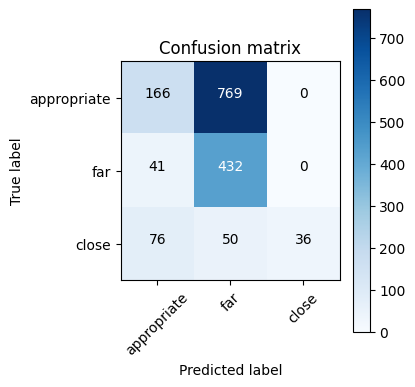

In [13]:
pred = [stat['pred_dis'] for stat in stats]
gt = [stat['label_dis'] for stat in stats]

show_matrix(pred, gt, ['appropriate', 'far', 'close'], "")

save plot image to :  E:\medical\depth\runs_remote\blip11\best\matrix_size_False.jpg


<Figure size 640x480 with 0 Axes>

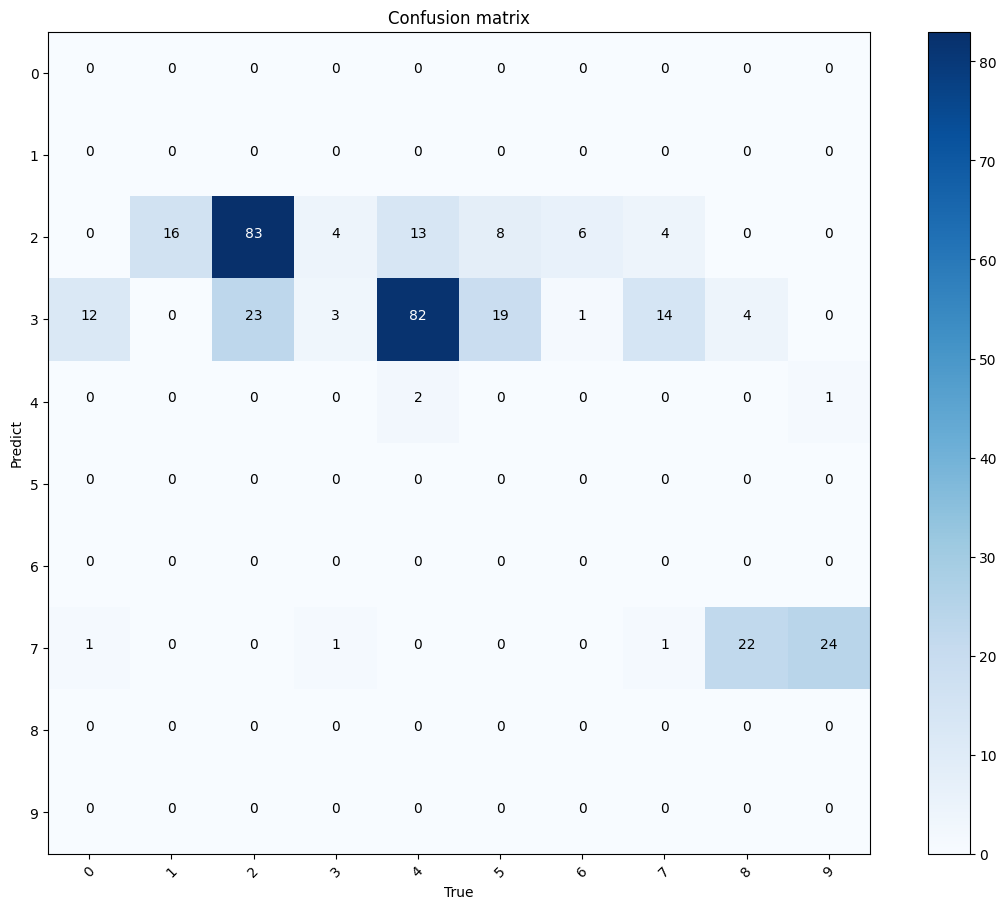

In [50]:
labels_step = ['2', '3', '4', '5', '6', '7', '8', '10', '15', '17']
pred = [stat['pred'] for stat in stats]
gt = [stat['label'] for stat in stats]
gt = [classify_step(x, labels_step) for x in gt]
pred = [classify_step(x, labels_step) for x in pred]

labels = [x for x in range(len(labels_step))]
show_matrix(pred, gt, labels, model_dir, tag="size")

In [51]:
import stats_holder

classes = [x for x in range(len(labels))]
cnf_matrix = confusion_matrix(pred, gt, labels=classes)
stats_holder.stats_matrix(cnf_matrix, labels, labels, len(pred))

model names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
dataset names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
model names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
dataset names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
miss count:  0 ,miss rate:  0.0
step: 1
diff <=0: 89 /344 ,rate:0.25872093023255816
diff <=1: 236 /344 ,rate:0.686046511627907
diff <=2: 292 /344 ,rate:0.8488372093023255
precision >=0.7: 89 /344 ,rate:0.25872093023255816
precision >=0.8: 89 /344 ,rate:0.25872093023255816
precision >=0.9: 89 /344 ,rate:0.25872093023255816
precision >=1.0: 89 /344 ,rate:0.25872093023255816


In [111]:
labels

['5', '8', '11', '14', '17', '20', '23', '26', '29', '32']